## Calcul de l'attention (avec numpy)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once_np(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = np.matmul(Q, K.T) / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = np.matmul(weights, V)
    return output

## Grille exhaustive qui teste toutes les combinaisons

* Mesure initiale : pour chaque block_size, effectue initial_repeats mesures et stocke les temps.

* Choix du candidat : identifie le bloc dont la moyenne des temps initiaux est la plus faible.

* Échauffement : relance 5 mesures supplémentaires sur ce “best” pour estimer son intervalle de confiance (IC) à 95 % (Student-t).

* Itération : jusqu’à max_iter, répète :

* Recalcule la moyenne, l’écart-type et l’IC supérieur du “best”.

* Sélectionne tous les blocs dont la moyenne courante ≤ IC supérieur.

* Mesure chacun de ces candidats une fois de plus.

* Met à jour le “best” en choisissant, parmi les candidats, celui à la plus petite moyenne.

* Test de confiance : pour chaque autre bloc, effectue un test t de Welch contre le “best” et calcule la p-value unilatérale.

* Arrêt : dès que toutes les p-values sont < 0.05 (95 % de confiance que le “best” est plus rapide), on sort.

* Résultat : retourne la taille de bloc optimale, toutes les mesures accumulées, et le nombre total de tests effectués.

In [ ]:
import numpy as np
import time
import math
from math import sqrt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt


# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once_np(x, block_size)
    return time.perf_counter() - start

# ------------------------
# Grille jusqu'à confiance 95%
# ------------------------
def exhaustive_grid_until_confidence(x, block_sizes,
                                     initial_repeats=2,
                                     confidence=0.95,
                                     max_iter=100):
    alpha = 1 - confidence
    block_sizes = sorted(set(block_sizes))
    n_blocks = len(block_sizes)
    results = {b: [] for b in block_sizes}

    # Phase initiale
    print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            time_val = measure_time(x, b)
            results[b].append(time_val)
        med = np.median(results[b])
        print(f"Bloc {b:<4} → médiane init : {med:.5f} s")

    total_tests = initial_repeats * n_blocks

    # Itérations
    for iteration in range(1, max_iter+1):
        print(f"\n🔁 Itération {iteration} : mesure de tous les blocs")
        # Mesurer chaque bloc
        for b in block_sizes:
            time_val = measure_time(x, b)
            results[b].append(time_val)
            print(f" Bloc {b:<4} dernière mesure : {time_val:.5f} s, essais : {len(results[b])}")
        total_tests += n_blocks

        # Statistiques par bloc
        means = {b: np.mean(results[b]) for b in block_sizes}
        vars_ = {b: np.var(results[b], ddof=1) for b in block_sizes}
        ns = {b: len(results[b]) for b in block_sizes}

        # Sélection du meilleur moyen actuel
        best = min(means, key=means.get)
        print(f" Meilleur moyen actuel : Bloc {best} (mean={means[best]:.5f})")

        # Test de confiance pair à pair
        all_confident = True
        for b in block_sizes:
            if b == best: 
                continue
            diff = means[b] - means[best]
            var_diff = vars_[b]/ns[b] + vars_[best]/ns[best]
            t_stat = diff / math.sqrt(var_diff)
            # Degrés de liberté Welch-Satterthwaite
            df = (var_diff**2) / ((vars_[b]**2)/(ns[b]**2*(ns[b]-1)) +
                                  (vars_[best]**2)/(ns[best]**2*(ns[best]-1)))
            p_value = 1 - student_t.cdf(t_stat, df)
            print(f"  -> Bloc {best} vs Bloc {b}: p={p_value:.4f}")
            if p_value >= alpha:
                all_confident = False

        if all_confident:
            print("\n✅ Confiance 95% atteinte pour le meilleur bloc.")
            break

    print(f"\n✅ Résultat final : Bloc {best}, tests totaux = {total_tests}")
    return best, results, total_tests


In [27]:
# ------------------------
# Exécution test
# ------------------------

seq_len, d_model = 2048, 64
x = np.random.randn(seq_len, d_model)
blocks = list(range(64, 1024, 32)) # Taille de bloc à tester

best, results, total_tests = exhaustive_grid_until_confidence(
    x, blocks, initial_repeats=3, confidence=0.95
)

🔍 Phase 1 : mesures initiales
Bloc 64   → médiane init : 0.00307 s
Bloc 96   → médiane init : 0.00294 s
Bloc 128  → médiane init : 0.00433 s
Bloc 160  → médiane init : 0.00451 s
Bloc 192  → médiane init : 0.00513 s
Bloc 224  → médiane init : 0.00592 s
Bloc 256  → médiane init : 0.00757 s
Bloc 288  → médiane init : 0.00740 s
Bloc 320  → médiane init : 0.00824 s
Bloc 352  → médiane init : 0.00864 s
Bloc 384  → médiane init : 0.00978 s
Bloc 416  → médiane init : 0.01185 s
Bloc 448  → médiane init : 0.01067 s
Bloc 480  → médiane init : 0.01102 s
Bloc 512  → médiane init : 0.01628 s
Bloc 544  → médiane init : 0.01545 s
Bloc 576  → médiane init : 0.01349 s
Bloc 608  → médiane init : 0.08496 s
Bloc 640  → médiane init : 0.07831 s
Bloc 672  → médiane init : 0.09402 s
Bloc 704  → médiane init : 0.09217 s
Bloc 736  → médiane init : 0.09313 s
Bloc 768  → médiane init : 0.09168 s
Bloc 800  → médiane init : 0.10054 s
Bloc 832  → médiane init : 0.10953 s
Bloc 864  → médiane init : 0.20336 s
Bloc 896

/tmp/ipykernel_43280/1544241572.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


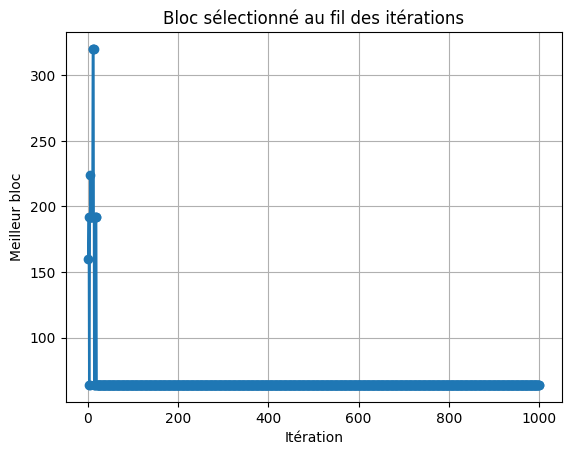

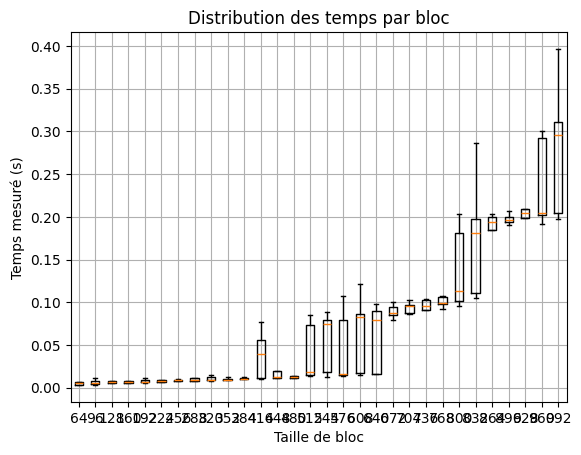

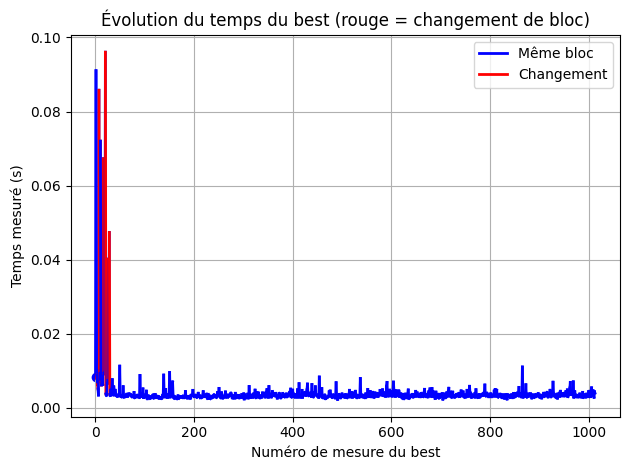

In [26]:
# ------------------------
# Tracés
# ------------------------

# 1) Évolution du bloc sélectionné par itération
plt.figure()
plt.plot(
    range(1, len(best_blocks_by_iter) + 1),
    best_blocks_by_iter,
    marker='o'
)
plt.xlabel("Itération")
plt.ylabel("Meilleur bloc")
plt.title("Bloc sélectionné au fil des itérations")
plt.grid(True)

# 2) Distribution des temps par bloc
plt.figure()
plt.boxplot(
    [results[b] for b in blocks],
    labels=[str(b) for b in blocks],
    showfliers=False
)
plt.xlabel("Taille de bloc")
plt.ylabel("Temps mesuré (s)")
plt.title("Distribution des temps par bloc")
plt.grid(True)

# 3) Temps du best à chaque mesure, segments colorés
# Préparation des données
indices = [idx for idx, _, _ in best_measurements]
blocks_seq = [bsz for _, bsz, _ in best_measurements]
times_seq  = [t   for _, _, t in best_measurements]
# Couleurs : rouge si changement de best, bleu sinon
colors = [
    'red' if curr != prev else 'blue'
    for prev, curr in zip(blocks_seq, blocks_seq[1:])
]
# Tracé segment par segment
plt.figure()
for i in range(len(times_seq)-1):
    plt.plot(
        [indices[i], indices[i+1]],
        [times_seq[i], times_seq[i+1]],
        color=colors[i],
        linewidth=2
    )
# Premier point
plt.scatter(indices[0], times_seq[0], color='blue')
plt.xlabel("Numéro de mesure du best")
plt.ylabel("Temps mesuré (s)")
plt.title("Évolution du temps du best (rouge = changement de bloc)")
plt.grid(True)
plt.legend([
    plt.Line2D([0],[0], color='blue', lw=2),
    plt.Line2D([0],[0], color='red',  lw=2)
], ["Même bloc", "Changement"])
plt.tight_layout()
plt.show()

## Benchmark intelligent 1

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm
from scipy.stats import t as student_t


In [6]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = Q @ K.T / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = weights @ V
    return output

# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once(x, block_size)
    return time.perf_counter() - start

In [ ]:
# -*- coding: utf-8 -*-
"""
Benchmark adaptatif jusqu'à décision probabiliste.

Vous devez fournir deux fonctions adaptées à votre code :
    • measure_time(x, block)   -> float (temps en secondes)
    • run_attention_once(x, b) -> None   (exécution « à blanc »)

Logique :
---------
À chaque itération, pour chaque bloc b ≠ best on calcule
    p_better = P( temps(b) < temps(best) )

    • Si max(p_better) > 0.50  →  on bascule le best sur le bloc qui
      possède cette proba maximale.
    • Si max(p_better) < 0.05  →  on est sûr à 95 % que ‘best’ est le
      plus rapide et on s’arrête.
    • Sinon on continue, en remesurant :
         – toujours le ‘best’,
         – tous les blocs dont p_better ≥ 0.05
"""

from math import sqrt
import numpy as np
from scipy.stats import t as student_t


def _prob_b_faster_than_a(mean_a, std_a, n_a, mean_b, std_b, n_b):
    """
    P(µ_b < µ_a) avec test de Welch sur la différence de moyennes.
    """
    # variance de la différence
    var = (std_a ** 2) / n_a + (std_b ** 2) / n_b
    if var == 0:
        return 0.5          # mesures identiques, probabilité 0.5

    se = sqrt(var)
    diff = mean_b - mean_a             # <0 si b plus rapide
    t_stat = diff / se                 # statistique observée

    # ddl Welch–Satterthwaite
    df = (
        var ** 2 /
        (((std_a ** 4) / (n_a ** 2 * (n_a - 1))) +
         ((std_b ** 4) / (n_b ** 2 * (n_b - 1))))
    )

    # P(diff < 0) = CDF(-|t|)
    p = student_t.cdf(-t_stat, df)
    return p


def smart_benchmark_probabilistic(
    x,
    block_sizes,
    *,
    p_switch: float         = 0.50,
    p_stop: float           = 0.05,
    initial_repeats: int    = 2,
    free_runs: int          = 1,
    extra_repeats_best: int = 1,
    max_iter: int           = 1_000,
    verbose: bool           = True,
):
    # ---------------------------------------------------------------
    # Préparation
    # ---------------------------------------------------------------
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}
    history = []          # [ (iter, best, {b: p_better}) ]
    best_track = []       # suivi du best

    # (1) réchauffe-caches
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once(x, b)
    if verbose:
        print("End of free runs")

    # (2) mesures initiales
    if verbose:
        print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            results[b].append(measure_time(x, b))
        if verbose:
            m = np.mean(results[b])
            print(f"Bloc {b:<4} → {m:.5f} s (n={len(results[b])})")

    # (3) best initial + répétitions bonus
    best = min(block_sizes, key=lambda b: np.mean(results[b]))
    if verbose:
        print(f"\nBest initial : {best}")
    for _ in range(extra_repeats_best):
        results[best].append(measure_time(x, best))

    # ---------------------------------------------------------------
    # Boucle principale
    # ---------------------------------------------------------------
    for it in range(1, max_iter + 1):
        # Stats de tous les blocs
        stats = {
            b: (
                np.mean(results[b]),
                np.std(results[b], ddof=1) if len(results[b]) > 1 else 0.0,
                len(results[b]),
            )
            for b in block_sizes
        }
        mean_best, std_best, n_best = stats[best]

        # Probabilités P(b < best)
        p_better = {}
        for b in block_sizes:
            if b == best:
                continue
            mean_b, std_b, n_b = stats[b]
            p = _prob_b_faster_than_a(
                mean_best, std_best, n_best,
                mean_b, std_b, n_b
            )
            p_better[b] = p

        history.append((it, best, p_better.copy()))
        best_track.append(best)

        if verbose:
            print(f"\n🔁 Itération {it}: best = {best}")
            for b, p in sorted(p_better.items()):
                print(f"  P({b} plus rapide que {best}) = {p:.3f}")

        # -----------------------------------------------------------
        # Décision : stop ? switch ?
        # -----------------------------------------------------------
        max_p = max(p_better.values(), default=0.0)
        if max_p < p_stop:
            if verbose:
                print("\n✅ Condition d’arrêt : toutes les probabilités "
                      f"< {p_stop:.2f}.")
            break

        # bloc candidat pour switch (plus forte proba > 0.50)
        if max_p > p_switch:
            new_best = max(p_better, key=p_better.get)
            if verbose:
                print(f"↪️ Switch du best : {best} → {new_best} "
                      f"(p = {max_p:.3f})")
            best = new_best
            # mettre à jour stats best
            mean_best, std_best, n_best = stats[best]

        # -----------------------------------------------------------
        # Sélection des blocs à remesurer
        #   – toujours le best
        #   – tous ceux avec p_better ≥ p_stop
        # -----------------------------------------------------------
        to_measure = [best] + [
            b for b, p in p_better.items() if p >= p_stop
        ]
        if verbose:
            print("Mesures supplémentaires :", to_measure)

        for b in to_measure:
            t = measure_time(x, b)
            results[b].append(t)
            if verbose:
                print(f"  Bloc {b:<4} → {t:.5f} s (n={len(results[b])})")

    # ---------------------------------------------------------------
    # Résultat final
    # ---------------------------------------------------------------
    if verbose:
        m_final = float(np.median(results[best]))
        tot = sum(len(v) for v in results.values())
        print(f"\n🏁 Best final : {best} (médiane = {m_final:.5f} s)")
        print("Mesures totales :", tot)

    return best, results, history, best_track


In [13]:
# ------------------------
# Exécution et double graphique
# ------------------------
seq_len, d_model = 81920, 64
x = np.random.randn(seq_len, d_model)
blocks = range(64, 1024, 128) # Taille de bloc à tester
best, results, hist, best_blocks_by_iter = smart_benchmark_probabilistic(x, 
                                                                            blocks,
                                                                            initial_repeats    = 2,
                                                                            free_runs          = 1, 
                                                                            extra_repeats_best = 0)

End of free runs
🔍 Phase 1 : mesures initiales
Bloc 64   → 0.17355 s (n=2)
Bloc 192  → 0.24392 s (n=2)
Bloc 320  → 0.55290 s (n=2)
Bloc 448  → 1.32387 s (n=2)
Bloc 576  → 2.00031 s (n=2)
Bloc 704  → 3.30531 s (n=2)
Bloc 832  → 4.54317 s (n=2)
Bloc 960  → 7.20646 s (n=2)

Best initial : 64

🔁 Itération 1: best = 64
  P(192 plus rapide que 64) = 0.165
  P(320 plus rapide que 64) = 0.015
  P(448 plus rapide que 64) = 0.001
  P(576 plus rapide que 64) = 0.004
  P(704 plus rapide que 64) = 0.003
  P(832 plus rapide que 64) = 0.016
  P(960 plus rapide que 64) = 0.002
Mesures supplémentaires : [64, 192]
  Bloc 64   → 0.32392 s (n=3)
  Bloc 192  → 0.24573 s (n=3)

🔁 Itération 2: best = 64
  P(192 plus rapide que 64) = 0.371
  P(320 plus rapide que 64) = 0.012
  P(448 plus rapide que 64) = 0.000
  P(576 plus rapide que 64) = 0.001
  P(704 plus rapide que 64) = 0.000
  P(832 plus rapide que 64) = 0.014
  P(960 plus rapide que 64) = 0.000
Mesures supplémentaires : [64, 192]
  Bloc 64   → 0.14101 

/tmp/ipykernel_43280/3133623855.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


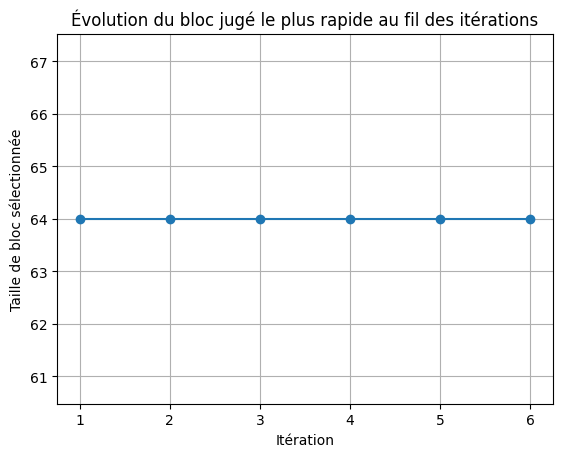

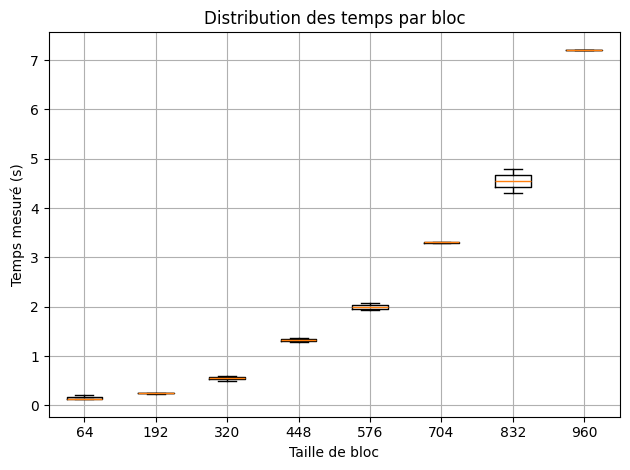

In [16]:
import matplotlib.pyplot as plt

# --- Graphique 1 : évolution du meilleur bloc par itération ---
plt.figure()
plt.plot(
    range(1, len(best_blocks_by_iter) + 1),
    best_blocks_by_iter,
    marker='o'
)
plt.xlabel("Itération")
plt.ylabel("Taille de bloc sélectionnée")
plt.title("Évolution du bloc jugé le plus rapide au fil des itérations")
plt.grid(True)

# --- Graphique 2 : distribution des temps mesurés par bloc ---
plt.figure()
# on alimente la boxplot avec la liste des temps pour chaque bloc
plt.boxplot(
    [results[b] for b in blocks],
    labels=[str(b) for b in blocks],
    showfliers=False
)
plt.xlabel("Taille de bloc")
plt.ylabel("Temps mesuré (s)")
plt.title("Distribution des temps par bloc")
plt.grid(True)

plt.tight_layout()
plt.show()


## Meilleur Benchmark

In [ ]:
# -*- coding: utf-8 -*-
"""
Benchmark adaptatif jusqu'à décision probabiliste,
avec traçage des performances.
"""

from math import sqrt
import numpy as np
from scipy.stats import t as student_t
import matplotlib.pyplot as plt

def _prob_b_faster_than_a(mean_a, std_a, n_a, mean_b, std_b, n_b):
    var = (std_a ** 2) / n_a + (std_b ** 2) / n_b
    if var == 0:
        return 0.5
    se = sqrt(var)
    diff = mean_b - mean_a
    t_stat = diff / se
    df = var**2 / (
        (std_a**4) / (n_a**2 * (n_a - 1)) +
        (std_b**4) / (n_b**2 * (n_b - 1))
    )
    return student_t.cdf(-t_stat, df)


def smart_benchmark_probabilistic(
    x,
    block_sizes,
    *,
    p_switch: float         = 0.50,
    p_stop: float           = 0.05,
    initial_repeats: int    = 2,
    free_runs: int          = 1,
    extra_repeats_best: int = 1,
    max_iter: int           = 1_000,
    verbose: bool           = True,
):
    # ---------------------------------------------------------------
    # Préparation
    # ---------------------------------------------------------------
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}
    history = []          # [ (iter, best, {b: p_better}) ]
    best_track = []       # suivi du best

    # Pour le troisième graphique :
    best_measurements = []            # liste de tuples (idx, best, t)
    global_measure_counter = 0        # compteur de mesures best

    # (1) réchauffe-caches
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once(x, b)
    if verbose:
        print("End of free runs")

    # (2) mesures initiales
    if verbose:
        print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            results[b].append(measure_time(x, b))
        if verbose:
            print(f"Bloc {b:<4} → {np.mean(results[b]):.5f} s (n={len(results[b])})")

    # (3) best initial + répétitions bonus
    best = min(block_sizes, key=lambda b: np.mean(results[b]))
    if verbose:
        print(f"\nBest initial : {best}")
    for _ in range(extra_repeats_best):
        t = measure_time(x, best)
        # enregistrement pour graphique 3
        global_measure_counter += 1
        best_measurements.append((global_measure_counter, best, t))
        results[best].append(t)

    # ---------------------------------------------------------------
    # Boucle principale
    # ---------------------------------------------------------------
    for it in range(1, max_iter + 1):
        # Stats de tous les blocs
        stats = {
            b: (
                np.mean(results[b]),
                np.std(results[b], ddof=1) if len(results[b]) > 1 else 0.0,
                len(results[b]),
            )
            for b in block_sizes
        }
        mean_best, std_best, n_best = stats[best]

        # Probabilités P(b < best)
        p_better = {}
        for b in block_sizes:
            if b == best:
                continue
            mean_b, std_b, n_b = stats[b]
            p_better[b] = _prob_b_faster_than_a(
                mean_best, std_best, n_best,
                mean_b, std_b, n_b
            )

        history.append((it, best, p_better.copy()))
        best_track.append(best)

        if verbose:
            print(f"\n🔁 Itération {it}: best = {best}")
            for b, p in sorted(p_better.items()):
                print(f"  P({b} plus rapide que {best}) = {p:.3f}")

        # Décision : stop ? switch ?
        max_p = max(p_better.values(), default=0.0)
        if max_p < p_stop:
            if verbose:
                print(f"\n✅ Arrêt, toutes proba < {p_stop:.2f}")
            break

        if max_p > p_switch:
            new_best = max(p_better, key=p_better.get)
            if verbose:
                print(f"↪️ Switch : {best} → {new_best} (p={max_p:.3f})")
            best = new_best

        # Sélection des blocs à remesurer
        to_measure = [best] + [b for b, p in p_better.items() if p >= p_stop]
        if verbose:
            print("Mesures supplémentaires :", to_measure)

        for b in to_measure:
            t = measure_time(x, b)
            # n’enregistrer que si c’est le best
            if b == best:
                global_measure_counter += 1
                best_measurements.append((global_measure_counter, best, t))
            results[b].append(t)
            if verbose:
                print(f"  Bloc {b:<4} → {t:.5f} s (n={len(results[b])})")

    # Résultat final
    if verbose:
        m_final = float(np.median(results[best]))
        tot = sum(len(v) for v in results.values())
        print(f"\n🏁 Best final : {best} (médiane={m_final:.5f} s), mesures={tot}")

    return best, results, history, best_track, best_measurements


End of free runs
🔍 Phase 1 : mesures initiales
Bloc 64   → 0.18060 s (n=2)
Bloc 192  → 0.25701 s (n=2)
Bloc 320  → 0.62539 s (n=2)
Bloc 448  → 1.39763 s (n=2)
Bloc 576  → 2.04753 s (n=2)
Bloc 704  → 3.19428 s (n=2)
Bloc 832  → 4.20357 s (n=2)
Bloc 960  → 6.55149 s (n=2)

Best initial : 64

🔁 Itération 1: best = 64
  P(192 plus rapide que 64) = 0.151
  P(320 plus rapide que 64) = 0.029
  P(448 plus rapide que 64) = 0.002
  P(576 plus rapide que 64) = 0.001
  P(704 plus rapide que 64) = 0.004
  P(832 plus rapide que 64) = 0.002
  P(960 plus rapide que 64) = 0.017
Mesures supplémentaires : [64, 192]
  Bloc 64   → 0.20893 s (n=3)
  Bloc 192  → 0.23467 s (n=3)

🔁 Itération 2: best = 64
  P(192 plus rapide que 64) = 0.067
  P(320 plus rapide que 64) = 0.002
  P(448 plus rapide que 64) = 0.000
  P(576 plus rapide que 64) = 0.002
  P(704 plus rapide que 64) = 0.000
  P(832 plus rapide que 64) = 0.004
  P(960 plus rapide que 64) = 0.017
Mesures supplémentaires : [64, 192]
  Bloc 64   → 0.13849 

In [ ]:
# ------------------------
# Exécution
# ------------------------
seq_len, d_model = 2048, 64
x = np.random.randn(seq_len, d_model)
blocks = list(range(64, 1024, 32))

best, results, history, best_blocks_by_iter, best_measurements = \
    smart_benchmark_probabilistic(
        x, blocks,
        initial_repeats    = 2,
        free_runs          = 1,
        extra_repeats_best = 0,
        verbose            = True
    )

End of free runs
🔍 Phase 1 : mesures initiales
Bloc 64   → 0.00712 s (n=2)
Bloc 96   → 0.04442 s (n=2)
Bloc 128  → 0.00691 s (n=2)
Bloc 160  → 0.00491 s (n=2)
Bloc 192  → 0.00539 s (n=2)
Bloc 224  → 0.00620 s (n=2)
Bloc 256  → 0.00749 s (n=2)
Bloc 288  → 0.01916 s (n=2)
Bloc 320  → 0.01034 s (n=2)
Bloc 352  → 0.00978 s (n=2)
Bloc 384  → 0.03472 s (n=2)
Bloc 416  → 0.01123 s (n=2)
Bloc 448  → 0.03661 s (n=2)
Bloc 480  → 0.01209 s (n=2)
Bloc 512  → 0.04249 s (n=2)
Bloc 544  → 0.04376 s (n=2)
Bloc 576  → 0.05044 s (n=2)
Bloc 608  → 0.04971 s (n=2)
Bloc 640  → 0.05284 s (n=2)
Bloc 672  → 0.05307 s (n=2)
Bloc 704  → 0.09980 s (n=2)
Bloc 736  → 0.14327 s (n=2)
Bloc 768  → 0.10010 s (n=2)
Bloc 800  → 0.10425 s (n=2)
Bloc 832  → 0.10374 s (n=2)
Bloc 864  → 0.23621 s (n=2)
Bloc 896  → 0.16160 s (n=2)
Bloc 928  → 0.24287 s (n=2)
Bloc 960  → 0.19882 s (n=2)
Bloc 992  → 0.24797 s (n=2)

Best initial : 160

🔁 Itération 1: best = 160
  P(64 plus rapide que 160) = 0.803
  P(96 plus rapide que 160) = 

/tmp/ipykernel_43280/1544241572.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


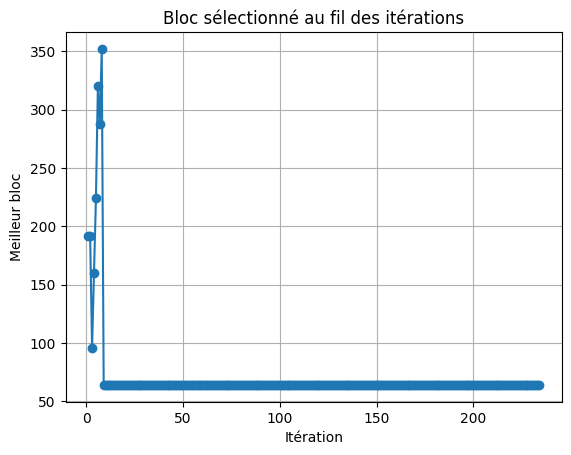

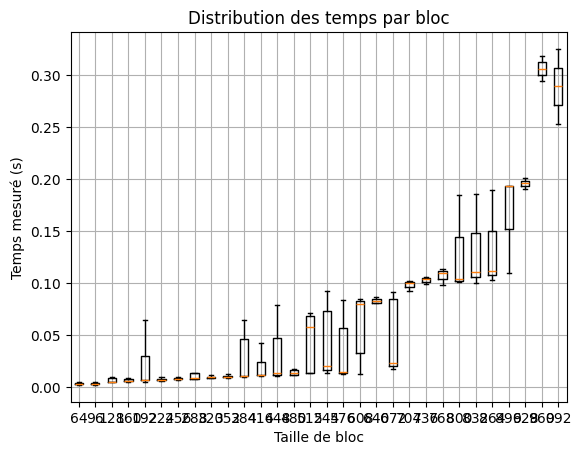

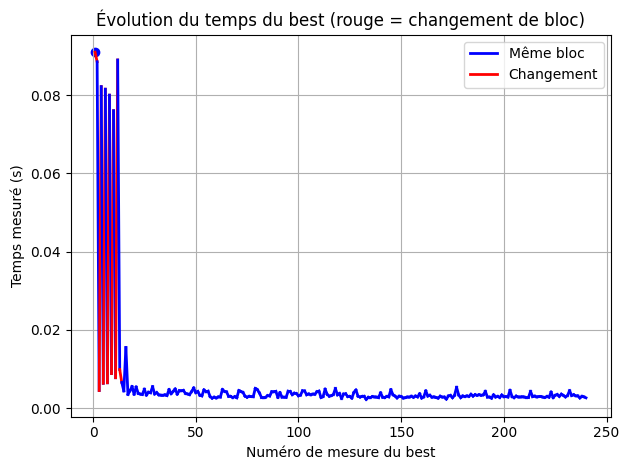

In [22]:
# ------------------------
# Tracés
# ------------------------

# 1) Évolution du bloc sélectionné par itération
plt.figure()
plt.plot(
    range(1, len(best_blocks_by_iter) + 1),
    best_blocks_by_iter,
    marker='o'
)
plt.xlabel("Itération")
plt.ylabel("Meilleur bloc")
plt.title("Bloc sélectionné au fil des itérations")
plt.grid(True)

# 2) Distribution des temps par bloc
plt.figure()
plt.boxplot(
    [results[b] for b in blocks],
    labels=[str(b) for b in blocks],
    showfliers=False
)
plt.xlabel("Taille de bloc")
plt.ylabel("Temps mesuré (s)")
plt.title("Distribution des temps par bloc")
plt.grid(True)

# 3) Temps du best à chaque mesure, segments colorés
# Préparation des données
indices = [idx for idx, _, _ in best_measurements]
blocks_seq = [bsz for _, bsz, _ in best_measurements]
times_seq  = [t   for _, _, t in best_measurements]
# Couleurs : rouge si changement de best, bleu sinon
colors = [
    'red' if curr != prev else 'blue'
    for prev, curr in zip(blocks_seq, blocks_seq[1:])
]
# Tracé segment par segment
plt.figure()
for i in range(len(times_seq)-1):
    plt.plot(
        [indices[i], indices[i+1]],
        [times_seq[i], times_seq[i+1]],
        color=colors[i],
        linewidth=2
    )
# Premier point
plt.scatter(indices[0], times_seq[0], color='blue')
plt.xlabel("Numéro de mesure du best")
plt.ylabel("Temps mesuré (s)")
plt.title("Évolution du temps du best (rouge = changement de bloc)")
plt.grid(True)
plt.legend([
    plt.Line2D([0],[0], color='blue', lw=2),
    plt.Line2D([0],[0], color='red',  lw=2)
], ["Même bloc", "Changement"])
plt.tight_layout()
plt.show()